## 1. What Problem Does Grad-CAM Solve?

Deep learning models, especially CNNs, are often seen as “black boxes.”
Grad-CAM helps **visualize what part of an input image is most important** for the model’s prediction.

It overlays a **heatmap** on the original image, showing where the model "looked" to make its decision.

---

## 2. Core Idea

Grad-CAM uses:

* **Feature maps** from the last convolutional layers (these retain spatial information about the image).
* **Gradients** of the target class score with respect to these feature maps (to see how important each map is).

It produces a **localization map** (heatmap) that highlights important regions.

---

## 3. Step-by-Step Process

Suppose you have a CNN classifying an image as *“dog.”*

1. **Forward pass:**

   * Input the image to the CNN.
   * Collect the feature maps $A^k$ from the last convolutional layer (index $k$ runs over channels).

2. **Backward pass (gradients):**

   * Compute gradients of the score for the target class $y^c$ (e.g., “dog”) w\.r.t. feature maps:

     $$
     \frac{\partial y^c}{\partial A^k}
     $$

3. **Compute importance weights:**

   * Average gradients spatially (global average pooling) to get one weight per feature map:

     $$
     \alpha^c_k = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}
     $$

     where $Z$ is the number of pixels in each feature map.

   * These weights ($\alpha^c_k$) tell how important each channel is for the class.

4. **Weighted sum of feature maps:**

   * Multiply feature maps by their weights and sum:

     $$
     L^c_{\text{Grad-CAM}} = \text{ReLU}\left( \sum_k \alpha^c_k A^k \right)
     $$

   * ReLU ensures only positive influences remain.

5. **Upsampling & overlay:**

   * Resize the coarse heatmap to the input image size.
   * Overlay on the image to highlight important regions.

---

## 4. Why It Works

* Last convolutional layers capture **high-level spatial features** (edges, textures, objects).
* Gradients show how sensitive the prediction is to those features.
* Weighted combination highlights the **regions the network focused on**.

---

## 5. Applications

* **Explainability**: Helps humans trust and debug CNNs.
* **Weakly-supervised localization**: Identify object locations without bounding box labels.
* **Medical imaging**: Verify if the model attends to disease-related regions (e.g., tumors).

---

## 6. Limitations

* Resolution is limited by the **last convolutional layer** (low spatial detail).
* Not guaranteed to be faithful to reasoning — just a useful approximation.
* Works only with convolution-based architectures (standard Grad-CAM doesn’t apply directly to Transformers).

---



## 7. PyTorch Grad-CAM implementation for VGG19.

Loading VGG19 model...
Target layer: ReLU()
Processing image: images/dog.jpg


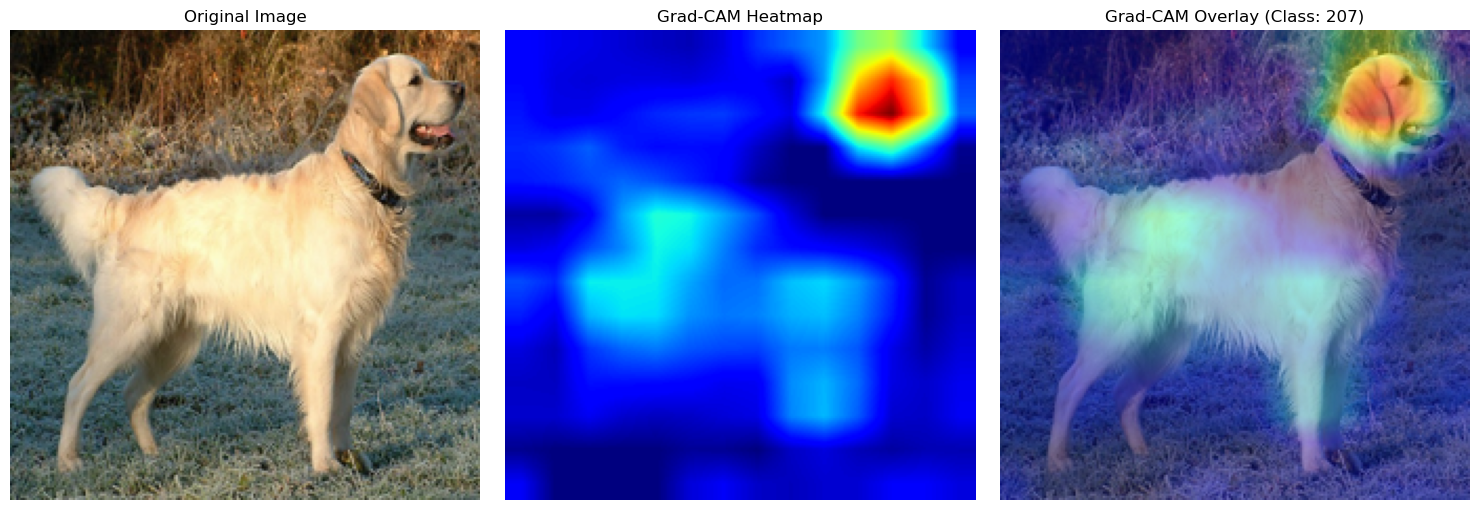

Grad-CAM visualization saved to: images/simple_gradcam.png
Predicted class index: 207


In [5]:
# Simple Grad-CAM for Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Simple preprocessing


def preprocess_image(image_path):
    """Load and preprocess image for VGG"""
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Resize to 224x224 (VGG input size)
    img = img.resize((224, 224))

    # Convert to tensor and normalize (ImageNet stats)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Add batch dimension
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor, img


class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        # Store activations and gradients
        self.activations = None
        self.gradients = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """Save the activations from forward pass"""
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """Save the gradients from backward pass"""
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx=None):
        """Generate Grad-CAM heatmap"""
        # Forward pass
        output = self.model(input_tensor)

        # Get predicted class if not specified
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        score = output[0, class_idx]
        score.backward()

        # Get activations and gradients
        activations = self.activations[0]  # Remove batch dimension
        gradients = self.gradients[0]      # Remove batch dimension

        # Calculate weights (global average pooling of gradients)
        weights = gradients.mean(dim=(1, 2))  # Average over spatial dimensions

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:])  # Initialize CAM
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU (only positive values)
        cam = F.relu(cam)

        # Normalize to 0-1
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam, class_idx


def visualize_gradcam(image, cam, class_idx, save_path="images/simple_gradcam.png"):
    """Simple visualization of Grad-CAM"""
    # Convert image to numpy
    img_np = np.array(image)

    # Resize CAM to image size
    cam_resized = F.interpolate(
        cam.unsqueeze(0).unsqueeze(0),
        size=(img_np.shape[0], img_np.shape[1]),
        mode='bilinear',
        align_corners=False
    ).squeeze().detach().numpy()

    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax1.imshow(img_np)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Grad-CAM heatmap
    ax2.imshow(cam_resized, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay
    ax3.imshow(img_np)
    ax3.imshow(cam_resized, cmap='jet', alpha=0.4)
    ax3.set_title(f'Grad-CAM Overlay (Class: {class_idx})')
    ax3.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Grad-CAM visualization saved to: {save_path}")
    print(f"Predicted class index: {class_idx}")


if __name__ == "__main__":
    # Load VGG19 model
    print("Loading VGG19 model...")
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
    model.eval()

    # Disable in-place operations to avoid hook issues
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

    # Get the last convolutional layer (before pooling)
    target_layer = model.features[-2]  # Last conv layer
    print(f"Target layer: {target_layer}")

    # Create Grad-CAM
    gradcam = SimpleGradCAM(model, target_layer)

    # Process image
    image_path = "images/dog.jpg"  # Change this to your image path
    print(f"Processing image: {image_path}")

    input_tensor, original_image = preprocess_image(image_path)

    # Generate Grad-CAM
    cam, predicted_class = gradcam.generate_cam(input_tensor)

    # Visualize
    visualize_gradcam(original_image, cam, predicted_class)

### 1. Forward Pass

Given an input image $x$ and a neural network $f$, we get a prediction:

$$y = f(x)$$

For a specific class $c$, the score is:
$$y^c = f^c(x)$$

### 2. Gradient Computation

We compute the gradient of the class score with respect to the feature maps of the last convolutional layer:

$$\frac{\partial y^c}{\partial A^k}$$

Where:
- $A^k$ is the $k$-th feature map from the last convolutional layer
- $y^c$ is the score for class $c$

### 3. Global Average Pooling

We compute the importance weights by global average pooling of the gradients:

$$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$$

Where:
- $\alpha_k^c$ is the importance weight for feature map $k$ and class $c$
- $Z$ is the normalization factor (total number of pixels in the feature map)
- $A_{ij}^k$ is the activation at spatial location $(i,j)$ in feature map $k$

### 4. Weighted Combination

The Grad-CAM localization map is computed as a weighted combination of the feature maps:

$$L_{Grad-CAM}^c = ReLU\left(\sum_k \alpha_k^c A^k\right)$$

Where:
- $L_{Grad-CAM}^c$ is the Grad-CAM localization map for class $c$
- $ReLU$ ensures we only consider features that have a positive influence on the class of interest

### 5. Normalization

Finally, we normalize the localization map to the range [0, 1]:

$$L_{normalized}^c = \frac{L_{Grad-CAM}^c - \min(L_{Grad-CAM}^c)}{\max(L_{Grad-CAM}^c) - \min(L_{Grad-CAM}^c)}$$

## Step-by-Step Algorithm

1. **Forward Pass**: Pass the input image through the network to get predictions
2. **Select Target Class**: Choose the class for which you want to generate the explanation
3. **Backward Pass**: Compute gradients of the target class score with respect to the last convolutional layer
4. **Compute Weights**: Apply global average pooling to the gradients to get importance weights
5. **Weighted Sum**: Multiply each feature map by its corresponding weight and sum them up
6. **Apply ReLU**: Keep only positive contributions
7. **Normalize**: Scale the result to [0, 1] range
8. **Upsample**: Resize the heatmap to match the input image size

## Code Implementation Breakdown

### 1. Hook Registration

```python
def save_activations(self, module, input, output):
    """Save the activations from forward pass"""
    self.activations = output

def save_gradients(self, module, grad_input, grad_output):
    """Save the gradients from backward pass"""
    self.gradients = grad_output[0]
```

**What happens**: PyTorch hooks capture the activations during forward pass and gradients during backward pass.

### 2. Forward Pass

```python
output = self.model(input_tensor)
```

**Mathematical equivalent**: $y = f(x)$

### 3. Backward Pass

```python
score = output[0, class_idx]
score.backward()
```

**Mathematical equivalent**: Computing $\frac{\partial y^c}{\partial A^k}$

### 4. Weight Calculation

```python
weights = gradients.mean(dim=(1, 2))
```

**Mathematical equivalent**: $\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$

### 5. Weighted Combination

```python
cam = torch.zeros(activations.shape[1:])
for i, w in enumerate(weights):
    cam += w * activations[i]
```

**Mathematical equivalent**: $\sum_k \alpha_k^c A^k$

### 6. ReLU and Normalization

```python
cam = F.relu(cam)
cam = cam - cam.min()
cam = cam / cam.max()
```

**Mathematical equivalent**: $ReLU(\sum_k \alpha_k^c A^k)$ followed by normalization

## Why Grad-CAM Works

### 1. Gradient Interpretation

The gradient $\frac{\partial y^c}{\partial A^k}$ tells us how much the class score changes when we change the activation at a particular location. Large gradients indicate that small changes in that region would significantly affect the prediction.

### 2. Global Average Pooling

By averaging the gradients spatially, we get a single importance score for each feature map. This captures the overall importance of each feature map for the target class.

### 3. ReLU Activation

The ReLU ensures we only highlight features that have a positive influence on the class of interest. Negative gradients indicate features that would decrease the class score.

## Advantages of Grad-CAM

1. **No Model Modification**: Works with any CNN without changing the architecture
2. **Class-Specific**: Can generate explanations for any class, not just the predicted one
3. **Fine-Grained**: Provides pixel-level importance scores
4. **Widely Applicable**: Works with any CNN architecture

## Limitations

1. **Low Resolution**: The heatmap resolution is limited by the last convolutional layer
2. **Single Layer**: Only considers the last convolutional layer
3. **No Negative Evidence**: ReLU removes information about features that decrease confidence

## Visual Interpretation

- **Red/Yellow Regions**: High importance for the target class
- **Blue/Dark Regions**: Low importance for the target class
- **Overlay**: Shows how the model's attention aligns with human perception

## Example Usage

```python
# Load model and create Grad-CAM
model = models.vgg19(pretrained=True)
target_layer = model.features[-2]  # Last conv layer
gradcam = SimpleGradCAM(model, target_layer)

# Generate explanation
cam, class_idx = gradcam.generate_cam(input_tensor)
```

## Key Takeaways

1. **Gradients are Key**: Grad-CAM uses gradients to understand feature importance
2. **Global Context**: Global average pooling provides a global view of feature importance
3. **Positive Focus**: ReLU ensures we only highlight positive contributions
4. **Interpretable**: The resulting heatmap is easy to interpret and visualize

Grad-CAM bridges the gap between the "black box" nature of deep neural networks and our need to understand their decision-making process, making AI more transparent and trustworthy.